In [1]:
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import os

# Evaluated data from literature

**Note:** Run the *Apps Evaluation.ipynb* notebook first to generate the evaluation data

In [2]:
directory = "**path to the generated app evaluation data**" 

In [3]:
def evaluate(y_true, y_pred_matrix):
    eval_results = pd.DataFrame()
    for metric in y_pred_matrix.columns:
        y_pred = y_pred_matrix[metric]
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        row = pd.Series({'TP':tp,'TN':tn,'FP':fp,'FN':fn,'Accuracy': accuracy, 'Recall':recall, 'Precision': precision, 'F1':f1},name=metric)
        eval_results = eval_results.append(row)
    return eval_results

In [4]:
filenames = os.listdir(directory)
filecount = len(filenames)
eval_results_sum = 0
for filename in filenames:
    results = pd.read_csv(f"{directory}/{filename}").drop(['state1','state2'], axis=1).astype(int)
    y_true = results.iloc[:,-1] # Extract the human classified labels
    y_pred_matrix = results.iloc[:,0:len(results.columns)-1] # Extract the classified labels
    eval_results = evaluate(y_true, y_pred_matrix)
    eval_results.to_csv(f'processed_{filename}')
    eval_results_sum += eval_results

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedM

In [5]:
eval_results_average = eval_results_sum/filecount
eval_results_average.to_csv(f'all_apps_avereged.csv')

In [6]:
eval_results_average

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1
DOM_RTED,2417.000000,5262.444444,3126.888889,25.888889,0.671265,0.986856,0.451301,0.588168
DOM_Levenshtein,2141.000000,5725.222222,2664.111111,301.888889,0.691715,0.914815,0.420307,0.554952
DOM_contentHash,2413.555556,3659.555556,4729.777778,29.333333,0.544482,0.985382,0.352899,0.487670
DOM_SIMHASH,2438.444444,2342.444444,6046.888889,4.444444,0.397069,0.997820,0.287085,0.423125
VISUAL_BlockHash,2041.333333,5082.666667,3306.666667,401.555556,0.612997,0.861456,0.425498,0.520052
VISUAL_PHash,1610.000000,4807.777778,3581.555556,832.888889,0.573286,0.749060,0.435682,0.460619
VISUAL_Hyst,2442.888889,10.888889,8378.444444,0.000000,0.229634,1.000000,0.227640,0.353321
VISUAL_PDiff,1947.777778,4675.000000,3714.333333,495.111111,0.583699,0.859430,0.359456,0.471679
VISUAL_SIFT,2313.666667,982.000000,7407.333333,129.222222,0.300974,0.942824,0.238822,0.361356
VISUAL_SSIM,179.444444,7327.111111,1062.222222,2263.444444,0.693615,0.111111,0.016058,0.028060


In [7]:
extracted_theirs = eval_results_average.T[['DOM_contentHash', 'DOM_Levenshtein', 'TLSH_hash2vec']]
extracted_theirs = extracted_theirs.rename(columns={'DOM_contentHash': 'TLSH Score (Hash)', 'DOM_Levenshtein': 'Levenshtein (DOM)', 'TLSH_hash2vec':'Euclidean (Hash)'})
extracted_theirs = extracted_theirs.T

# Extract data from our evaluation framework

In [8]:
directory = "**Path to the directory where the data from our evaluation is contained*"

In [9]:
import json

with open(directory + '/endpoints.json') as f:
    endpoints = json.load(f)

with open(directory + '/interactions.json') as f:
    interactions = json.load(f)

### Parsing interactions as states

In [10]:
from tqdm import tqdm

state_names = list()
clustering_input = list()
for interaction in tqdm(interactions):
    state_hash = interaction['hash']
    state_name = interaction['_id']['$oid']
    dom = interaction['response']['data']
    clustering_input.append({'name': state_name, 'hash': state_hash, 'dom':dom})
    state_names.append(state_name)

100%|█████████████████████████████████████| 286/286 [00:00<00:00, 409130.61it/s]


In [11]:
import sys
sys.path.insert(0, '..') # Allow relative imports
from scanner.Detection.ClusteringBased.Clustering.DBSCANClustering import DBSCANClustering
clustering = DBSCANClustering()

In [12]:
n_clusters_nativ, labels_nativ = clustering.cluster(clustering_input, distance_type='tlsh', field_for_index='name')
print(f'DBSCAN TLSH Nativ found {n_clusters_nativ} clusters')

100%|███████████████████████████████████████| 286/286 [00:00<00:00, 1388.23it/s]


DBSCAN TLSH Nativ found 8 clusters


In [13]:
n_clusters_hash2vec, labels_hash2vec = clustering.cluster(clustering_input, distance_type='hash2vec', field_for_index='name')
print(f'DBSCAN TLSH Hash2Vec found {n_clusters_hash2vec} clusters')

DBSCAN TLSH Hash2Vec found 20 clusters


In [14]:
n_clusters_levenshtein_dom, labels_levenshtein_dom = clustering.cluster(clustering_input, distance_type='levenshtein', field_for_index='dom')
print(f'DBSCAN TLSH Levenshtain DOM found {n_clusters_levenshtein_dom} clusters')

100%|████████████████████████████████████████| 286/286 [00:00<00:00, 369.30it/s]


DBSCAN TLSH Levenshtain DOM found 9 clusters


In [15]:
import itertools
state_pairs = list(itertools.combinations(state_names,2))

In [16]:
def detect_duplicates(labels, state_pairs, state_names):
    duplicate_states = []
    for state_pair in tqdm(state_pairs):
        first_state_idx = state_names.index(state_pair[0])
        first_state_label = labels[first_state_idx]

        second_state_idx = state_names.index(state_pair[1])
        second_state_label = labels[second_state_idx]

        if first_state_label == second_state_label:
            duplicate_states.append(state_pair)
    return duplicate_states

In [17]:
our_duplicates_dbscan_tlsh_nativ = detect_duplicates(labels_nativ, state_pairs, state_names)

100%|██████████████████████████████████| 40755/40755 [00:00<00:00, 73128.02it/s]


In [18]:
print(f'Duplicates found with our TLSH nativ method: {len(our_duplicates_dbscan_tlsh_nativ)}')

Duplicates found with our TLSH nativ method: 7722


In [19]:
our_duplicates_dbscan_tlsh_hash2vec = detect_duplicates(labels_hash2vec, state_pairs, state_names)

100%|██████████████████████████████████| 40755/40755 [00:00<00:00, 69014.03it/s]


In [20]:
print(f'Duplicates found with our TLSH Hash2Vec method: {len(our_duplicates_dbscan_tlsh_hash2vec)}')

Duplicates found with our TLSH Hash2Vec method: 2277


In [21]:
our_duplicates_dbscan_levenshtain_dom = detect_duplicates(labels_levenshtein_dom, state_pairs, state_names)

100%|██████████████████████████████████| 40755/40755 [00:00<00:00, 71108.91it/s]


In [22]:
print(f'Duplicates found with our TLSH Levenshtain DOM method: {len(our_duplicates_dbscan_levenshtain_dom)}')

Duplicates found with our TLSH Levenshtain DOM method: 6391


In [23]:
def create_classified_bool_array(duplicate_state_pairs):
    bool_array = []
    for state_pair in state_pairs:
        if state_pair in duplicate_state_pairs:
            bool_array.append(True)
        else:
            bool_array.append(False)
    return bool_array

In [24]:
def find_state_interaction_path(state_name):
    for interaction in interactions:
        if interaction['_id']['$oid'] == state_name:
            return interaction['request']['endpoint']['path']

In [25]:
ground_truth_bool_array = list()
for state_pair in state_pairs:
    first_state_name = state_pair[0]
    second_state_name = state_pair[1]

    first_state_interaction_path = find_state_interaction_path(first_state_name)
    second_state_interaction_path = find_state_interaction_path(second_state_name)

    duplicates = False
    if first_state_interaction_path == second_state_interaction_path:
        duplicates = True

    ground_truth_bool_array.append(duplicates)

In [26]:
results = pd.DataFrame()
results['state1'] = [i[0] for i in state_pairs]
results['state2'] = [i[1] for i in state_pairs]

In [27]:
results['TLSH_nativ'] = create_classified_bool_array(our_duplicates_dbscan_tlsh_nativ)
results['TLSH_hash2vec'] = create_classified_bool_array(our_duplicates_dbscan_tlsh_hash2vec)
results['Levenshtain_Dom'] = create_classified_bool_array(our_duplicates_dbscan_levenshtain_dom)
results['Ground Truth'] = ground_truth_bool_array

In [28]:
results

,state1,state2,TLSH_nativ,TLSH_hash2vec,Levenshtain_Dom,Ground Truth
0,62a9a1cfabe24e90f67f9d11,62a9a1d0abe24e90f67f9d22,True,True,True,True
1,62a9a1cfabe24e90f67f9d11,62a9a1d0abe24e90f67f9d2b,False,False,False,False
2,62a9a1cfabe24e90f67f9d11,62a9a1d0abe24e90f67f9d2e,False,False,False,False
3,62a9a1cfabe24e90f67f9d11,62a9a1d0abe24e90f67f9d32,False,False,False,False
4,62a9a1cfabe24e90f67f9d11,62a9a1d0abe24e90f67f9d36,False,False,False,False
...,...,...,...,...,...,...
40750,62a9a1e8abe24e90f67fa484,62a9a1e8abe24e90f67fa490,True,True,True,True
40751,62a9a1e8abe24e90f67fa484,62a9a1e9abe24e90f67fa496,False,False,False,False
40752,62a9a1e8abe24e90f67fa48a,62a9a1e8abe24e90f67fa490,True,False,True,False
40753,62a9a1e8abe24e90f67fa48a,62a9a1e9abe24e90f67fa496,False,False,False,False


In [29]:
evaluation = results.drop(['state1','state2'], axis=1).astype(int)

In [30]:
y_true = evaluation.iloc[:,-1] # Extract the human classified labels

In [31]:
y_pred_matrix = evaluation.iloc[:,0:len(evaluation.columns)-1] # Extract the classified labels

In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

eval_results = pd.DataFrame()

for metric in y_pred_matrix.columns:
    y_pred = y_pred_matrix[metric]
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    row = pd.Series({'TP':tp,'TN':tn,'FP':fp,'FN':fn,'Accuracy': accuracy, 'Recall':recall, 'Precision': precision, 'F1':f1},name=metric)

    eval_results = eval_results.append(row)

In [33]:
eval_results

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1
TLSH_nativ,2156.0,32912.0,5566.0,121.0,0.860459,0.94686,0.279202,0.431243
TLSH_hash2vec,2156.0,38357.0,121.0,121.0,0.994062,0.94686,0.946860,0.946860
Levenshtain_Dom,2156.0,34243.0,4235.0,121.0,0.893117,0.94686,0.337349,0.497462


In [34]:
extracte_ours = eval_results.T[['TLSH_nativ', 'Levenshtain_Dom', 'TLSH_hash2vec']]
extracte_ours = extracte_ours.rename(columns={'TLSH_nativ': 'TLSH Score (Hash)', 'Levenshtain_Dom': 'Levenshtein (DOM)', 'TLSH_hash2vec':'Euclidean (Hash)'})
extracte_ours = extracte_ours.T

# Plot data

In [35]:
extracted_theirs

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1
TLSH Score (Hash),2413.555556,3659.555556,4729.777778,29.333333,0.544482,0.985382,0.352899,0.487670
Levenshtein (DOM),2141.000000,5725.222222,2664.111111,301.888889,0.691715,0.914815,0.420307,0.554952
Euclidean (Hash),651.777778,8315.444444,73.888889,1791.111111,0.825516,0.245753,0.858146,0.302605


In [36]:
extracte_ours

,TP,TN,FP,FN,Accuracy,Recall,Precision,F1
TLSH Score (Hash),2156.0,32912.0,5566.0,121.0,0.860459,0.94686,0.279202,0.431243
Levenshtein (DOM),2156.0,34243.0,4235.0,121.0,0.893117,0.94686,0.337349,0.497462
Euclidean (Hash),2156.0,38357.0,121.0,121.0,0.994062,0.94686,0.946860,0.946860


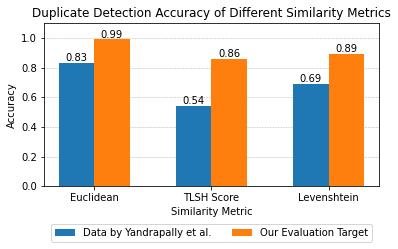

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Numbers of pairs of bars you want
N = 3

# Position of bars on x-axis
ind = np.arange(N)

# Width of a bar
width = 0.3
offset = 0

fig, ax = plt.subplots(figsize = (6,3))
distance_metrics = list(extracte_ours.index)

acc_ours = extracte_ours['Accuracy']
acc_ours = round(acc_ours,2)
acc_ours = acc_ours[['Euclidean (Hash)', 'TLSH Score (Hash)', 'Levenshtein (DOM)']]

acc_theirs = extracted_theirs['Accuracy']
acc_theirs = round(acc_theirs,2)
acc_theirs = acc_theirs[['Euclidean (Hash)', 'TLSH Score (Hash)', 'Levenshtein (DOM)']]

ax.grid(linestyle = '--', linewidth = 0.5, axis = 'y', zorder=0)

ax.bar(ind, acc_theirs, width, zorder=3)

#ax.bar(ind, acc_theirs, width, yerr=acc_theirs.std(),zorder=3, capsize=5)
ax.bar(ind + width + offset, acc_ours, width, zorder=3)
#ax.bar(ind + width + offset, acc_ours, width, yerr=acc_ours.std(), zorder=3, capsize=5)

for container in ax.containers:
    ax.bar_label(container)

ax.set_title("Duplicate Detection Accuracy of Different Similarity Metrics")
ax.set_xlabel("Similarity Metric")
ax.set_ylabel("Accuracy")

ax.set_xticks(ind + width / 2, ['Euclidean', 'TLSH Score', 'Levenshtein'])
ax.set_ylim(0,1.1)

ax.legend(['Data by Yandrapally et al.', 'Our Evaluation Target'],loc='upper center', bbox_to_anchor=(0.5, -0.2),
      fancybox=True, shadow=False, ncol=2)

plt.savefig('distance_metrics_accuracy_ours_vs_literature.svg', bbox_inches='tight', format='svg')
